In [1]:
!pip install yfinance  mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.8 MB/s eta 0:00:00a 0:00:01


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import os
import cv2
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import Counter
import warnings

warnings.filterwarnings('ignore')

2026-01-11 14:56:08.370596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768143368.797799      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768143368.929344      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768143369.966946      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768143369.967062      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768143369.967066      55 computation_placer.cc:177] computation placer alr

# Data Pipeline – `DataCollector` Class Documentation

## Overview

The `DataCollector` class is responsible for the **entire data ingestion and preprocessing pipeline** used in a technical-analysis-based machine learning workflow.
Its responsibilities include:

* Fetching historical stock price data
* Converting time-series price data into candlestick chart images
* Detecting classical trading patterns
* Labeling images for supervised learning
* Visualizing sample outputs for inspection

This design keeps **data collection, feature generation, and labeling tightly coupled** while remaining modular.

---

## Class Initialization

```python
def __init__(self, tickers, start_date, end_date):
```

### Purpose

Initializes the data pipeline with user-defined stock symbols and date range.

### Parameters

* `tickers` (`list[str]`): Stock symbols (e.g., `['AAPL', 'MSFT']`)
* `start_date` (`str`): Start date for historical data
* `end_date` (`str`): End date for historical data

### Internal State

* `self.data`: Dictionary storing historical price DataFrames keyed by ticker

---

## Fetching Market Data

```python
def fetch_data(self):
```

### Purpose

Downloads historical OHLCV stock data from Yahoo Finance using `yfinance`.

### How It Works

1. Iterates through each ticker
2. Fetches historical price data for the given date range
3. Stores the resulting DataFrame in `self.data`

### Output

```python
{
  'AAPL': DataFrame,
  'MSFT': DataFrame,
  ...
}
```

This method **must be called before any image generation**.

---

## Candlestick Image Generation

```python
def create_candlestick_images(self, window_size=15, output_dir='chart_images'):
```

### Purpose

Transforms time-series price data into **image-based representations** suitable for computer vision models (CNNs, Vision Transformers, etc.).

### Key Concepts

* **Sliding Window**: Each image represents `window_size` consecutive trading days
* **Future Offset**: Leaves room after the window to avoid label leakage
* **Image-Label Pairing**: Each image is paired with a detected price pattern

---

### Styling Configuration

```python
mc = mpf.make_marketcolors(up='green', down='red', ...)
s = mpf.make_mpf_style(...)
```

Creates a **clean, standardized red/green candlestick style**, ensuring:

* Visual consistency
* No gridlines
* White background
* ML-friendly appearance

---

### Image Creation Loop

```python
for i in range(window_size, len(df) - 5):
```

For each rolling window:

1. Extracts a slice of historical prices
2. Renders a candlestick chart using `mplfinance`
3. Removes axes, borders, and whitespace
4. Saves a square PNG image
5. Detects chart patterns
6. Appends image path and label

### Output

* `image_paths`: List of saved image file paths
* `labels`: Corresponding pattern labels

---

## Pattern Detection Pipeline

```python
def detect_patterns(self, df):
```

### Purpose

Assigns a **single label** to each candlestick image based on technical analysis patterns.

### Detection Priority (Top-Down)

1. **Head & Shoulders** (structural, multi-candle)
2. **Hammer** (single-candle reversal)
3. **Doji** (indecision candle)
4. `no_pattern` (default)

This priority prevents overlapping pattern conflicts.

---

## Head & Shoulders Detection

```python
def _detect_head_shoulders(self, highs, lows, sensitivity=0.03):
```

### Pattern Logic

* Divides the window into three equal zones:

  * Left Shoulder
  * Head
  * Right Shoulder
* Ensures:

  * Head peak is the highest
  * Shoulders are similar in height
  * Valley between peaks exists

### Why This Works

This approach captures **macro price structure**, making it robust to candle noise.

---

## Doji Detection

```python
def _detect_doji(self, opens, closes, highs, lows):
```

### Pattern Logic

* Candle body is very small relative to total range
* Indicates market indecision

### Formula

```
|Close - Open| / (High - Low) < 5%
```

### Scope

* Only evaluates the **last candle** in the window

---

## Hammer Detection

```python
def _detect_hammer(self, opens, closes, highs, lows):
```

### Pattern Logic

Hammer candles signal potential bullish reversals.

Conditions:

1. Small real body
2. Long lower wick (≥ 2× body)
3. Minimal upper wick

### Why Last Candle Only?

Candlestick patterns are **contextual end-of-window signals**.

---

## Sample Visualization

```python
def display_stock_samples(self, num_samples=4):
```

### Purpose

Visually validates the dataset by displaying randomly selected chart images per stock.

### How It Works

* Collects all images for each ticker
* Randomly samples `num_samples`
* Displays them in a grid
* Gracefully handles missing images

### Why This Matters

This step is critical for:

* Verifying image quality
* Checking labeling consistency
* Detecting preprocessing bugs early

---

## Summary

### What This Pipeline Achieves

✔ Converts raw financial time-series into ML-ready images
✔ Automatically labels data using technical analysis
✔ Supports supervised learning workflows
✔ Maintains visual consistency for deep learning

In [3]:
# Part 1: Data Pipeline
class DataCollector:
    def __init__(self, tickers, start_date, end_date):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.data = {}
        
    def fetch_data(self):
        """Fetch historical price data"""
        for ticker in self.tickers:
            print(f"Fetching data for {ticker}...")
            stock = yf.Ticker(ticker)
            df = stock.history(start=self.start_date, end=self.end_date)
            self.data[ticker] = df
        return self.data

    def create_candlestick_images(self, window_size=15, output_dir='chart_images'):
        """Convert time series to candlestick chart images"""
        os.makedirs(output_dir, exist_ok=True)
        
        image_paths = []
        labels = []
        
        # Define a custom red/green style (mplfinance default is often close to this 'yahoo')
        mc = mpf.make_marketcolors(up='green', down='red', edge='black', wick='black', inherit=True)
        s = mpf.make_mpf_style(marketcolors=mc, gridstyle='', facecolor='white')
    
        for ticker, df in self.data.items():
            print(f"Creating images for {ticker}...")
            
            # Ensure we have enough data for the window
            if len(df) <= window_size + 5:
                continue
    
            for i in range(window_size, len(df) - 5):  # Leave room for future price action
                # Extract window of data
                window_df = df.iloc[i-window_size:i]
                
                # Create candlestick chart using the custom style
                fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
                mpf.plot(window_df, 
                         type='candle', 
                         style=s, # Use our custom red/green style
                         ax=ax, 
                         volume=False, 
                         update_width_config=dict(candle_linewidth=1.5, candle_width=0.7), 
                         show_nontrading=False)
    
                # Force clean image: No borders, no whitespace
                ax.axis('off')
                fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
                
                # Save image
                img_name = f"{ticker}_{i}.png"
                img_path = os.path.join(output_dir, img_name)
                plt.savefig(img_path, bbox_inches='tight', pad_inches=0, facecolor='white')
                plt.close(fig) # Explicitly close fig to save memory
                
                image_paths.append(img_path)
                
                # Label based on pattern detection
                label = self.detect_patterns(window_df)
                labels.append(label)
        
        return image_paths, labels

    
    def detect_patterns(self, df):
        """Detect trading patterns in price data"""
        # Convert to numpy for easier calculation
        highs = df['High'].values
        lows = df['Low'].values
        closes = df['Close'].values
        opens = df['Open'].values
        
        # 1. Head & Shoulders (Structural - looks at the whole window)
        if self._detect_head_shoulders(highs, lows):
            return 'head_shoulders'
        
        # 2. Hammer (Candlestick - looks at the last candle)
        if self._detect_hammer(opens, closes, highs, lows):
            return 'hammer'
            
        # 3. Doji (Candlestick - looks at the last candle)
        if self._detect_doji(opens, closes, highs, lows):
            return 'doji'
        
        return 'no_pattern'
    
    def _detect_head_shoulders(self, highs, lows, sensitivity=0.03):
        """Detect Head and Shoulders pattern using 3-zone peak analysis"""
        if len(highs) < 20: # H&S needs a wider window to be visible
            return False
        
        # Divide the window into three logical zones for Left Shoulder, Head, and Right Shoulder
        third = len(highs) // 3
        
        ls_zone = highs[:third]
        head_zone = highs[third:2*third]
        rs_zone = highs[2*third:]
        
        ls_peak = np.max(ls_zone)
        head_peak = np.max(head_zone)
        rs_peak = np.max(rs_zone)
        
        # 1. Head must be the highest point in the entire window
        if head_peak <= ls_peak or head_peak <= rs_peak:
            return False
            
        # 2. Shoulders should be roughly similar in height (within sensitivity %)
        shoulder_diff = abs(ls_peak - rs_peak) / head_peak
        
        # 3. Ensure the "valleys" (troughs) between peaks are lower than shoulders
        mid_valley = np.min(highs[len(ls_zone):len(ls_zone)+len(head_zone)])
        
        if shoulder_diff < sensitivity and mid_valley < ls_peak:
            return True
        
        return False
    
    def _detect_doji(self, opens, closes, highs, lows, threshold=0.05):
        """Detect Doji pattern (Body is less than 5% of the total candle range)"""
        # Look at the final candle in the window
        body_size = abs(closes[-1] - opens[-1])
        total_range = highs[-1] - lows[-1]
        
        if total_range == 0:
            return False
        
        return (body_size / total_range) < threshold
    
    def _detect_hammer(self, opens, closes, highs, lows, body_to_range_max=0.3, wick_ratio=2):
        """Detect Hammer pattern (Small body at top, long lower wick)"""
        # Look at the final candle in the window
        op, cl, hi, lo = opens[-1], closes[-1], highs[-1], lows[-1]
        
        body_size = abs(cl - op)
        total_range = hi - lo
        lower_wick = min(op, cl) - lo
        upper_wick = hi - max(op, cl)
        
        if total_range == 0:
            return False
            
        # Hammer criteria: 
        # 1. Body is small (less than 30% of range)
        # 2. Lower wick is at least 2x the body size
        # 3. Very small or no upper wick
        is_hammer = (body_size / total_range < body_to_range_max) and \
                    (lower_wick > body_size * wick_ratio) and \
                    (upper_wick < body_size)
                    
        return is_hammer
    
    def display_stock_samples(self, num_samples=4):
        """Display 4 sample images for each stock in a 5x4 grid"""
        fig, axes = plt.subplots(len(self.tickers), num_samples, figsize=(15, 20))
        fig.suptitle('Stock Chart Samples (4 per stock)', fontsize=16, y=1.02)
        
        for i, ticker in enumerate(self.tickers):
            # Get all images for this ticker
            ticker_images = []
            for file in os.listdir('chart_images'):
                if file.startswith(ticker):
                    ticker_images.append(os.path.join('chart_images', file))
            
            # Randomly select num_samples images
            if len(ticker_images) >= num_samples:
                selected_images = np.random.choice(ticker_images, num_samples, replace=False)
                
                for j, img_path in enumerate(selected_images):
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    
                    axes[i, j].imshow(img)
                    axes[i, j].set_title(f'{ticker} - Sample {j+1}')
                    axes[i, j].axis('off')
            else:
                for j in range(num_samples):
                    axes[i, j].text(0.5, 0.5, f'No image\navailable', 
                                   ha='center', va='center', fontsize=12)
                    axes[i, j].axis('off')
        
        plt.tight_layout()
        plt.show()


# Dataset Creation and Management – `PatternDataset` Class

## Overview

The `PatternDataset` class is responsible for **turning labeled candlestick chart images into a machine-learning–ready dataset**.
It handles:

* Label encoding and decoding
* Dataset balancing
* Image loading and normalization
* Train/validation/test splitting
* Data visualization
* Targeted data augmentation for minority classes

This class cleanly separates **data engineering concerns** from **model architecture and training logic**.

---

## Class Initialization

```python
def __init__(self, image_paths, labels, img_size=(128, 128)):
```

### Purpose

Initializes the dataset manager with image locations, labels, and preprocessing configuration.

### Parameters

* `image_paths` (`list[str]`): File paths to candlestick images
* `labels` (`list[str]`): Pattern labels corresponding to each image
* `img_size` (`tuple`): Target image resolution for the model

### Label Encoding

```python
self.label_map = {
    'head_shoulders': 0,
    'doji': 1,
    'hammer': 2,
    'no_pattern': 3
}
```

* Converts human-readable labels into **numerical class IDs**
* `reverse_label_map` allows decoding predictions back to text

This mapping is critical for classification models.

---

## Dataset Balancing

```python
def create_balanced_dataset(self, max_samples_per_class=500):
```

### Purpose

Prevents class imbalance by **capping the maximum number of samples per pattern**.

### Why This Matters

Technical patterns rarely occur with equal frequency.
Without balancing:

* Models overfit dominant classes
* Minority patterns (Doji, Hammer) are ignored

---

### How It Works

1. Groups image paths by label
2. Randomly downsamples classes exceeding `max_samples_per_class`
3. Reconstructs balanced image and label lists

### Output

* `balanced_paths`: Balanced list of image paths
* `balanced_labels`: Corresponding balanced labels

---

## Image Loading and Preprocessing

```python
def load_and_preprocess_images(self, image_paths, labels):
```

### Purpose

Loads raw images from disk and prepares them for neural network input.

---

### Processing Steps

For each image:

1. **Load** using OpenCV
2. **Resize** to fixed dimensions (`img_size`)
3. **Normalize** pixel values to `[0, 1]`
4. **Encode label** using `label_map`

### Error Handling

* Skips corrupted or unreadable files
* Prevents pipeline crashes

---

### Output

* `X`: NumPy array of images → shape `(N, H, W, C)`
* `y`: NumPy array of encoded labels → shape `(N,)`

This output is **model-ready**.

---

## Train / Validation / Test Split

```python
def train_val_test_split(self, X, y, test_size=0.2, val_size=0.2):
```

### Purpose

Splits the dataset into three disjoint sets for **robust model evaluation**.

---

### Splitting Strategy

1. **Test set**

   * Held out completely
   * Never seen during training or tuning

2. **Validation set**

   * Used for hyperparameter tuning and early stopping

3. **Training set**

   * Used to learn model weights

---

### Key Features

* **Stratified splitting** ensures each set maintains class distribution
* Fixed `random_state` ensures reproducibility

### Output

```python
X_train, X_val, X_test,
y_train, y_val, y_test
```

---

## Pattern Sample Visualization

```python
def display_pattern_samples(self, num_samples=5):
```

### Purpose

Visually inspects data quality by showing sample images for each pattern.

---

### Layout

* 4 rows → one per pattern
* `num_samples` columns per row
* Total grid size: `4 × num_samples`

---

### Why This Matters

This step helps:

* Verify correct labeling
* Detect visual artifacts
* Confirm pattern distinguishability
* Catch preprocessing bugs early

---

## Targeted Data Augmentation

```python
def augment_training_data(self, X_train, y_train):
```

### Purpose

Increases diversity for **minority classes only**, improving model generalization.

---

### Augmented Classes

* **Doji (1)**
* **Hammer (2)**

These patterns:

* Occur less frequently
* Are visually subtle
* Benefit most from augmentation

---

### Augmentation Techniques

#### 1. Horizontal Flip

```python
cv2.flip(img, 1)
```

* Preserves pattern semantics
* Introduces mirrored variations

---

#### 2. Slight Rotation

```python
cv2.getRotationMatrix2D(..., 5 degrees)
```

* Simulates different price slopes
* Avoids unrealistic distortions

---

### Final Steps

* Original images are always retained
* Augmented dataset is shuffled to prevent ordering bias

### Output

```python
X_train_aug, y_train_aug
```

---

## Summary

### What This Class Accomplishes

✔ Converts image files into structured ML datasets
✔ Mitigates class imbalance
✔ Applies safe, domain-aware augmentation
✔ Enables clean dataset splits
✔ Provides strong visual validation tools

In [4]:
# Part 2: Dataset Creation and Management
class PatternDataset:
    def __init__(self, image_paths, labels, img_size=(128, 128)):
        self.image_paths = image_paths
        self.labels = labels
        self.img_size = img_size
        self.label_map = {'head_shoulders': 0, 'doji': 1, 'hammer': 2, 'no_pattern': 3}
        self.reverse_label_map = {v: k for k, v in self.label_map.items()}
        
    def create_balanced_dataset(self, max_samples_per_class=500):
        """Balance the dataset by limiting samples per class"""
        from collections import defaultdict
        
        # Group by label
        label_groups = defaultdict(list)
        for path, label in zip(self.image_paths, self.labels):
            label_groups[label].append(path)
        
        # Balance samples
        balanced_paths = []
        balanced_labels = []
        
        for label, paths in label_groups.items():
            # Limit number of samples per class
            if len(paths) > max_samples_per_class:
                paths = np.random.choice(paths, max_samples_per_class, replace=False)
            
            balanced_paths.extend(paths)
            balanced_labels.extend([label] * len(paths))
        
        return balanced_paths, balanced_labels
    
    def load_and_preprocess_images(self, image_paths, labels):
        """Load and preprocess images for model training"""
        X = []
        y = []
        
        for path, label in zip(image_paths, labels):
            try:
                # Load image
                img = cv2.imread(path)
                if img is None:
                    continue
                
                # Resize
                img = cv2.resize(img, self.img_size)
                
                # Normalize
                img = img.astype('float32') / 255.0
                
                X.append(img)
                y.append(self.label_map[label])
            except Exception as e:
                print(f"Error loading {path}: {e}")
                continue
        
        return np.array(X), np.array(y)
    
    def train_val_test_split(self, X, y, test_size=0.2, val_size=0.2):
        """Split data into train, validation, and test sets"""
        # First split: train+val vs test
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
        
        # Second split: train vs val
        val_relative_size = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, 
            test_size=val_relative_size, 
            random_state=42, 
            stratify=y_train_val
        )
        
        return X_train, X_val, X_test, y_train, y_val, y_test
    
    def display_pattern_samples(self, num_samples=5):
        """Display sample images for each pattern in a 4x5 grid"""
        patterns = ['head_shoulders', 'doji', 'hammer', 'no_pattern']
        fig, axes = plt.subplots(4, num_samples, figsize=(15, 12))
        fig.suptitle('Pattern Samples (5 per pattern)', fontsize=16, y=1.02)
        
        for i, pattern in enumerate(patterns):
            # Get all images for this pattern
            pattern_images = []
            pattern_labels = []
            
            for path, label in zip(self.image_paths, self.labels):
                if label == pattern:
                    pattern_images.append(path)
                    pattern_labels.append(label)
            
            # Select num_samples images
            if len(pattern_images) >= num_samples:
                selected_indices = np.random.choice(len(pattern_images), num_samples, replace=False)
                
                for j, idx in enumerate(selected_indices):
                    img = cv2.imread(pattern_images[idx])
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    
                    axes[i, j].imshow(img)
                    axes[i, j].set_title(f'{pattern}\nSample {j+1}', fontsize=10)
                    axes[i, j].axis('off')
            else:
                for j in range(num_samples):
                    axes[i, j].text(0.5, 0.5, f'Not enough\n{pattern} samples', 
                                   ha='center', va='center', fontsize=10)
                    axes[i, j].axis('off')
        
        plt.tight_layout()
        plt.show()

    def augment_training_data(self, X_train, y_train):
        """
        Manually augment minority classes in the training set.
        Increases data diversity for Hammer and Doji classes specifically.
        """
        augmented_X = []
        augmented_y = []
        
        print("Starting data augmentation for minority classes...")
        
        for img, label in zip(X_train, y_train):
            # Always keep original
            augmented_X.append(img)
            augmented_y.append(label)
            
            # Label Map: {'head_shoulders': 0, 'doji': 1, 'hammer': 2, 'no_pattern': 3}
            # Augment only Doji (1) and Hammer (2)
            if label in [1, 2]:
                # 1. Horizontal Flip (Creates a variation of the pattern)
                flip_img = cv2.flip(img, 1)
                augmented_X.append(flip_img)
                augmented_y.append(label)
                
                # 2. Slight Rotation (Simulates different price slopes)
                center = (img.shape[1] // 2, img.shape[0] // 2)
                matrix = cv2.getRotationMatrix2D(center, 5, 1.0) # 5 degree tilt
                rot_img = cv2.warpAffine(img, matrix, (img.shape[1], img.shape[0]), borderMode=cv2.BORDER_REPLICATE)
                augmented_X.append(rot_img)
                augmented_y.append(label)

        X_train_aug = np.array(augmented_X)
        y_train_aug = np.array(augmented_y)
        
        # Shuffle the augmented dataset
        shuffled_indices = np.random.permutation(len(X_train_aug))
        return X_train_aug[shuffled_indices], y_train_aug[shuffled_indices]


# CNN Model Development – Pattern Classification

## Overview

This module defines the **modeling and training layer** of the pipeline.
It focuses on:

* Designing a CNN architecture suitable for small, image-based financial datasets
* Tracking meaningful multi-class metrics beyond accuracy
* Applying robust training strategies (early stopping, LR scheduling)
* Providing both **custom CNN** and **transfer learning** options

The design prioritizes **generalization over raw capacity**, which is critical in financial pattern recognition.

---

## Custom Multi-Class Metrics Callback

```python
class MultiClassMetrics(keras.callbacks.Callback):
```

### Purpose

Keras does not natively compute **precision, recall, and F1-score** for multi-class problems during training.
This callback fills that gap.

---

### Initialization

```python
def __init__(self, x_val, y_val):
```

* Stores the full validation dataset
* Allows metric computation at the end of every epoch

This avoids batch-level metric noise.

---

### Epoch-End Evaluation

```python
def on_epoch_end(self, epoch, logs=None):
```

#### What Happens

1. Runs inference on the entire validation set
2. Converts softmax probabilities into class predictions
3. Computes:

   * Weighted Precision
   * Weighted Recall
   * Weighted F1-score
4. Injects metrics into Keras `logs` so they appear in training history

#### Why Weighted Metrics?

* Class imbalance is common in pattern detection
* Weighted averaging reflects real-world performance more accurately

---

## CNN Model Wrapper

```python
class PatternCNN:
```

### Purpose

Encapsulates **model creation, compilation, training, and evaluation** into a clean, reusable interface.

---

## Model Initialization

```python
def __init__(self, input_shape=(128, 128, 3), num_classes=4):
```

* Defines input image dimensions
* Sets number of output classes
* Automatically builds the CNN model

---

## Transfer Learning Model (Optional)

```python
def build_model1(self):
```

### Purpose

Provides a **transfer learning alternative** using MobileNetV2 for cases where:

* Dataset size is extremely limited
* Faster convergence is needed

---

### Architecture Breakdown

1. **Pretrained MobileNetV2 backbone**

   * Loaded with ImageNet weights
   * Feature extractor only (`include_top=False`)
2. **Frozen weights**

   * Prevents overfitting
   * Preserves learned visual features
3. **Custom classification head**

   * Global Average Pooling
   * Dense + Dropout
   * Softmax output layer

### When to Use

* Very small datasets (<1k images)
* Limited training time
* Baseline experimentation

---

## Custom CNN Architecture (Primary Model)

```python
def build_model(self):
```

### Design Philosophy

This model is **deliberately simple** to avoid overfitting on financial chart images.

---

### Architecture Breakdown

#### Input Layer

```python
layers.Input(shape=self.input_shape)
```

Defines the image input tensor.

---

#### Block 1 – Edge Detection

```python
Conv2D(16) → MaxPooling
```

* Learns basic candlestick edges and shadows
* Reduces spatial resolution

---

#### Block 2 – Shape Recognition

```python
Conv2D(32) → MaxPooling
```

* Learns higher-level chart structures
* Identifies pattern geometry

---

#### Global Average Pooling (Key Design Choice)

```python
layers.GlobalAveragePooling2D()
```

**Why this matters:**

* Replaces large fully connected layers
* Reduces parameter count by orders of magnitude
* Improves generalization on small datasets

This is the **core reason this model performs well with limited data**.

---

#### Classification Head

```python
Dense → Dropout → Softmax
```

* Dense layer for feature mixing
* Dropout for regularization
* Softmax for multi-class probability output

---

## Model Compilation

```python
def compile_model(self, learning_rate=0.001):
```

### Choices Explained

* **Adam optimizer**: Adaptive and stable for noisy gradients
* **Sparse categorical crossentropy**:

  * Efficient integer label encoding
* **Accuracy metric**:

  * Tracked for quick sanity checks

More meaningful metrics are handled via the custom callback.

---

## Model Training

```python
def train(self, X_train, y_train, X_val, y_val):
```

### Training Enhancements

#### 1. Custom Metrics Callback

Tracks:

* Precision
* Recall
* F1-score

#### 2. Early Stopping

```python
patience=10
```

* Prevents overfitting
* Restores best model weights

#### 3. Learning Rate Reduction

```python
ReduceLROnPlateau
```

* Lowers learning rate when validation loss plateaus
* Helps fine-tune convergence

---

### Output

Returns the Keras `history` object with:

* Loss
* Accuracy
* Precision
* Recall
* F1-score

---

## Model Evaluation

```python
def evaluate(self, X_test, y_test):
```

### Purpose

Performs **final, unbiased evaluation** on the test set.

---

### Evaluation Process

1. Generates predictions
2. Converts probabilities to class labels
3. Computes:

   * Loss
   * Accuracy
   * Precision
   * Recall
   * F1-score

### Why Use sklearn Here?

* Consistent metric definitions
* Full-dataset evaluation
* No training-side bias

---

## Summary

### What This Model Stack Provides

✔ CNN architecture optimized for small datasets
✔ Domain-aware design for financial chart patterns
✔ Robust multi-class metrics tracking
✔ Strong regularization and training controls
✔ Optional transfer learning fallback

In [5]:
# Part 3: CNN Model Development
from sklearn.metrics import precision_score, recall_score, f1_score
import keras

class MultiClassMetrics(keras.callbacks.Callback):
    def __init__(self, x_val, y_val):
        super().__init__()
        self.x_val = x_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Get predictions for the whole validation set
        y_pred_probs = self.model.predict(self.x_val, verbose=0)
        y_pred = np.argmax(y_pred_probs, axis=1)
        
        # Calculate weighted metrics for multi-class
        val_precision = precision_score(self.y_val, y_pred, average='weighted', zero_division=0)
        val_recall = recall_score(self.y_val, y_pred, average='weighted', zero_division=0)
        val_f1 = f1_score(self.y_val, y_pred, average='weighted', zero_division=0)
        
        # Add to logs so Keras can track them in 'history'
        logs['val_precision'] = val_precision
        logs['val_recall'] = val_recall
        logs['val_f1'] = val_f1
        
        print(f" - val_precision: {val_precision:.4f} - val_recall: {val_recall:.4f} - val_f1: {val_f1:.4f}")

class PatternCNN:
    def __init__(self, input_shape=(128, 128, 3), num_classes=4):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()

    def build_model1(self):
        """Use Transfer Learning for small dataset success"""
        # Load pre-trained MobileNetV2 without the top layer
        base_model = keras.applications.MobileNetV2(
            input_shape=self.input_shape,
            include_top=False,
            weights='imagenet'
        )
        
        # Freeze the pre-trained weights
        base_model.trainable = False
        
        model = keras.Sequential([
            # Preprocessing layer for MobileNetV2
            layers.Lambda(lambda x: keras.applications.mobilenet_v2.preprocess_input(x)),
            
            base_model,
            
            layers.GlobalAveragePooling2D(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(self.num_classes, activation='softmax')
        ])
        return model

        
    def build_model(self):
        """Simplified CNN architecture for small financial datasets"""
        model = keras.Sequential([
                    layers.Input(shape=self.input_shape),
                    # Block 1: Basic Edges
                    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
                    layers.MaxPooling2D((2, 2)),
                    
                    # Block 2: Shape Detection
                    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
                    layers.MaxPooling2D((2, 2)),
                    
                    # KEY CHANGE: GlobalAveragePooling reduces parameters from millions to thousands
                    # This is the "secret" to 70% accuracy on small image datasets.
                    layers.GlobalAveragePooling2D(),
                    
                    layers.Dense(32, activation='relu'),
                    layers.Dropout(0.2),
                    layers.Dense(self.num_classes, activation='softmax')])
        return model

    def compile_model(self, learning_rate=0.001):
        """Standard Adam often works better with GlobalAveragePooling"""
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

    
    def train(self, X_train, y_train, X_val, y_val, epochs=30, batch_size=32):
        """Train the model with custom metrics tracking"""
        # Instantiate our new custom callback
        metrics_callback = MultiClassMetrics(X_val, y_val)
        
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True
        )
        
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
        )
        
        # Include metrics_callback in the callbacks list
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr, metrics_callback],
            verbose=1
        )
        return history

    def evaluate(self, X_test, y_test):
        """Final evaluation using sklearn for accuracy across all classes"""
        y_pred_probs = self.model.predict(X_test, verbose=0)
        y_pred = np.argmax(y_pred_probs, axis=1)
        
        results = self.model.evaluate(X_test, y_test, verbose=0)
        
        return {
            'loss': results[0],
            'accuracy': results[1],
            'precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
            'recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
            'f1_score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
        }



# Backtesting & Evaluation

## Overview

The **Backtesting module** bridges the gap between **model accuracy** and **real-world trading performance**.
Instead of asking *“Did the model classify patterns correctly?”*, this stage asks:

> *“Would this model actually make money?”*

It provides:

* Signal generation from CNN predictions
* A simplified trading strategy
* Capital growth simulation
* Risk-adjusted performance metrics
* Comparison against a random baseline

---

## Backtester Class

```python
class Backtester:
```

### Purpose

Encapsulates all logic needed to:

* Convert classification outputs into trading decisions
* Simulate capital evolution
* Quantify strategy performance

This keeps **financial evaluation separate from ML training**, which is best practice.

---

## Initialization

```python
def __init__(self, model, data, label_map):
```

### Parameters

* `model`: Trained CNN model
* `data`: Market price data (must include `Close`)
* `label_map`: Mapping of pattern names to class indices

### Internal State

* `reverse_label_map`: Converts predicted class IDs back to pattern names

---

## Signal Generation

```python
def generate_signals(self, X, threshold=0.7):
```

### Purpose

Transforms model predictions into **actionable trading signals**.

---

### How It Works

1. Runs inference on image inputs
2. Extracts:

   * Maximum softmax probability
   * Predicted class index
3. Applies a **confidence threshold**

---

### Decision Logic

| Condition                                | Output Signal |
| ---------------------------------------- | ------------- |
| High confidence & pattern ≠ `no_pattern` | Pattern name  |
| Low confidence or `no_pattern`           | `hold`        |

This prevents:

* Overtrading
* Acting on uncertain predictions

---

### Output

* `signals`: List of trading actions (`pattern` or `hold`)
* `confidence_scores`: Model confidence for each decision

---

## Strategy Performance Calculation

```python
def calculate_performance(self, signals, actual_returns):
```

### Purpose

Simulates a **simple rule-based trading strategy** driven by detected patterns.

---

### Strategy Rules

* **Entry**: Buy when a pattern is detected
* **Exit**: Sell the next period
* **Position size**: 10% of available capital
* **Direction**: Long-only

This keeps evaluation:

* Interpretable
* Conservative
* Pattern-focused

---

### Capital Simulation

* Capital updates after every trade
* Tracks wins and losses
* Stores per-trade returns

---

### Performance Metrics

| Metric           | Meaning                   |
| ---------------- | ------------------------- |
| Final Capital    | Ending portfolio value    |
| Total Return (%) | Overall profitability     |
| Total Trades     | Number of executed trades |
| Win Rate         | % profitable trades       |
| Sharpe Ratio     | Risk-adjusted performance |

---

### Sharpe Ratio (Simplified)

```text
mean(trade_returns) / std(trade_returns) × √252
```

* Assumes daily frequency
* Penalizes volatility
* Adds numerical stability

---

### Output

Returns a dictionary containing:

```python
{
  'final_capital',
  'total_return_pct',
  'win_rate',
  'sharpe_ratio',
  'trades'
}
```

---

## Random Strategy Benchmark

```python
def compare_random_strategy(self, actual_returns):
```

### Purpose

Establishes a **baseline performance** to answer:

> *Is the CNN better than randomness?*

---

### How It Works

* Simulates `num_simulations` random strategies
* Randomly chooses:

  * Buy (20%)
  * Hold (60%)
  * Sell (20%)
* Applies the same capital allocation rules

---

### Output Metrics

* Mean final capital
* Standard deviation
* Best and worst outcomes

This provides **statistical context** for model performance.

---

## Training Metrics Visualization

```python
def plot_results(history):
```

### Purpose

Visualizes **model learning dynamics** during training.

---

### Plots

#### 1. Accuracy

* Training vs Validation
* Detects overfitting or underfitting

#### 2. Validation F1-Score

* Collected via custom callback
* Reflects real multi-class performance

---

### Why F1 Matters Here

* Accuracy alone can be misleading
* F1 balances precision and recall
* Especially important with imbalanced patterns

---

## End-to-End Evaluation Flow

```text
CNN Predictions
      ↓
Confidence-Filtered Signals
      ↓
Trading Simulation
      ↓
Performance Metrics
      ↓
Random Strategy Comparison
```

---

## Key Strengths of This Backtesting Design

✔ Separates ML performance from trading logic
✔ Uses confidence-aware decision making
✔ Applies realistic capital constraints
✔ Includes risk-adjusted metrics
✔ Benchmarks against randomness

---

## Important Limitations (By Design)

* No transaction costs
* No slippage
* Single-period holding
* No short selling
* No regime filtering

These simplifications make results **interpretable**, not overstated.

---

In [6]:
# Part 4: Backtesting & Evaluation
class Backtester:
    def __init__(self, model, data, label_map):
        self.model = model
        self.data = data
        self.label_map = label_map
        self.reverse_label_map = {v: k for k, v in label_map.items()}
        
    def generate_signals(self, X, threshold=0.7):
        """Generate trading signals from model predictions"""
        predictions = self.model.predict(X, verbose=0)
        
        signals = []
        confidence_scores = []
        
        for pred in predictions:
            max_prob = np.max(pred)
            predicted_class = np.argmax(pred)
            
            if max_prob > threshold and self.reverse_label_map[predicted_class] != 'no_pattern':
                signals.append(self.reverse_label_map[predicted_class])
            else:
                signals.append('hold')
            confidence_scores.append(max_prob)
        
        return signals, confidence_scores
    
    def calculate_performance(self, signals, actual_returns, initial_capital=10000):
        """Calculate trading performance metrics"""
        capital = initial_capital
        positions = []
        trades = []
        wins = 0
        losses = 0
        
        for i in range(len(signals) - 1):
            if signals[i] != 'hold':
                # Simplified: Buy on pattern detection, sell next period
                entry_price = self.data['Close'].iloc[i]
                exit_price = self.data['Close'].iloc[i + 1]
                
                return_pct = (exit_price - entry_price) / entry_price
                
                # Simple long-only strategy
                position_return = capital * 0.1 * return_pct  # Invest 10% of capital
                capital += position_return
                
                trades.append(position_return)
                
                if position_return > 0:
                    wins += 1
                else:
                    losses += 1
        
        # Calculate metrics
        total_trades = len(trades)
        win_rate = wins / total_trades if total_trades > 0 else 0
        
        total_return = capital - initial_capital
        total_return_pct = (total_return / initial_capital) * 100
        
        # Sharpe ratio (simplified)
        if len(trades) > 1:
            returns_array = np.array(trades)
            sharpe_ratio = np.mean(returns_array) / (np.std(returns_array) + 1e-7) * np.sqrt(252)
        else:
            sharpe_ratio = 0
        
        return {
            'initial_capital': initial_capital,
            'final_capital': capital,
            'total_return': total_return,
            'total_return_pct': total_return_pct,
            'total_trades': total_trades,
            'win_rate': win_rate,
            'sharpe_ratio': sharpe_ratio,
            'trades': trades
        }
    
    def compare_random_strategy(self, actual_returns, initial_capital=10000, num_simulations=1000):
        """Compare with random trading strategy"""
        random_results = []
        
        for _ in range(num_simulations):
            # Generate random signals
            random_signals = np.random.choice(['buy', 'hold', 'sell'], len(actual_returns), p=[0.2, 0.6, 0.2])
            
            # Calculate performance
            capital = initial_capital
            for i in range(len(random_signals) - 1):
                if random_signals[i] == 'buy':
                    return_pct = actual_returns[i]
                    capital += capital * 0.1 * return_pct
            
            random_results.append(capital)
        
        return {
            'mean_final_capital': np.mean(random_results),
            'std_final_capital': np.std(random_results),
            'best_random': np.max(random_results),
            'worst_random': np.min(random_results)
        }

def plot_results(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    
    # Plot F1-Score (collected by our custom callback)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['val_f1'], label='Val F1-Score', color='red')
    plt.title('Validation F1-Score over Epochs')
    plt.legend()
    
    plt.show()


FINANCIAL PATTERN RECOGNITION SYSTEM

1. Collecting data and creating images...
Fetching data for AAPL...
Fetching data for MSFT...
Fetching data for GOOGL...
Fetching data for AMZN...
Fetching data for TSLA...
Creating images for AAPL...
Creating images for MSFT...
Creating images for GOOGL...
Creating images for AMZN...
Creating images for TSLA...

Created 2385 images
Label distribution: Counter({'no_pattern': 1931, 'head_shoulders': 234, 'doji': 124, 'hammer': 96})

Displaying stock samples (4 per stock)...


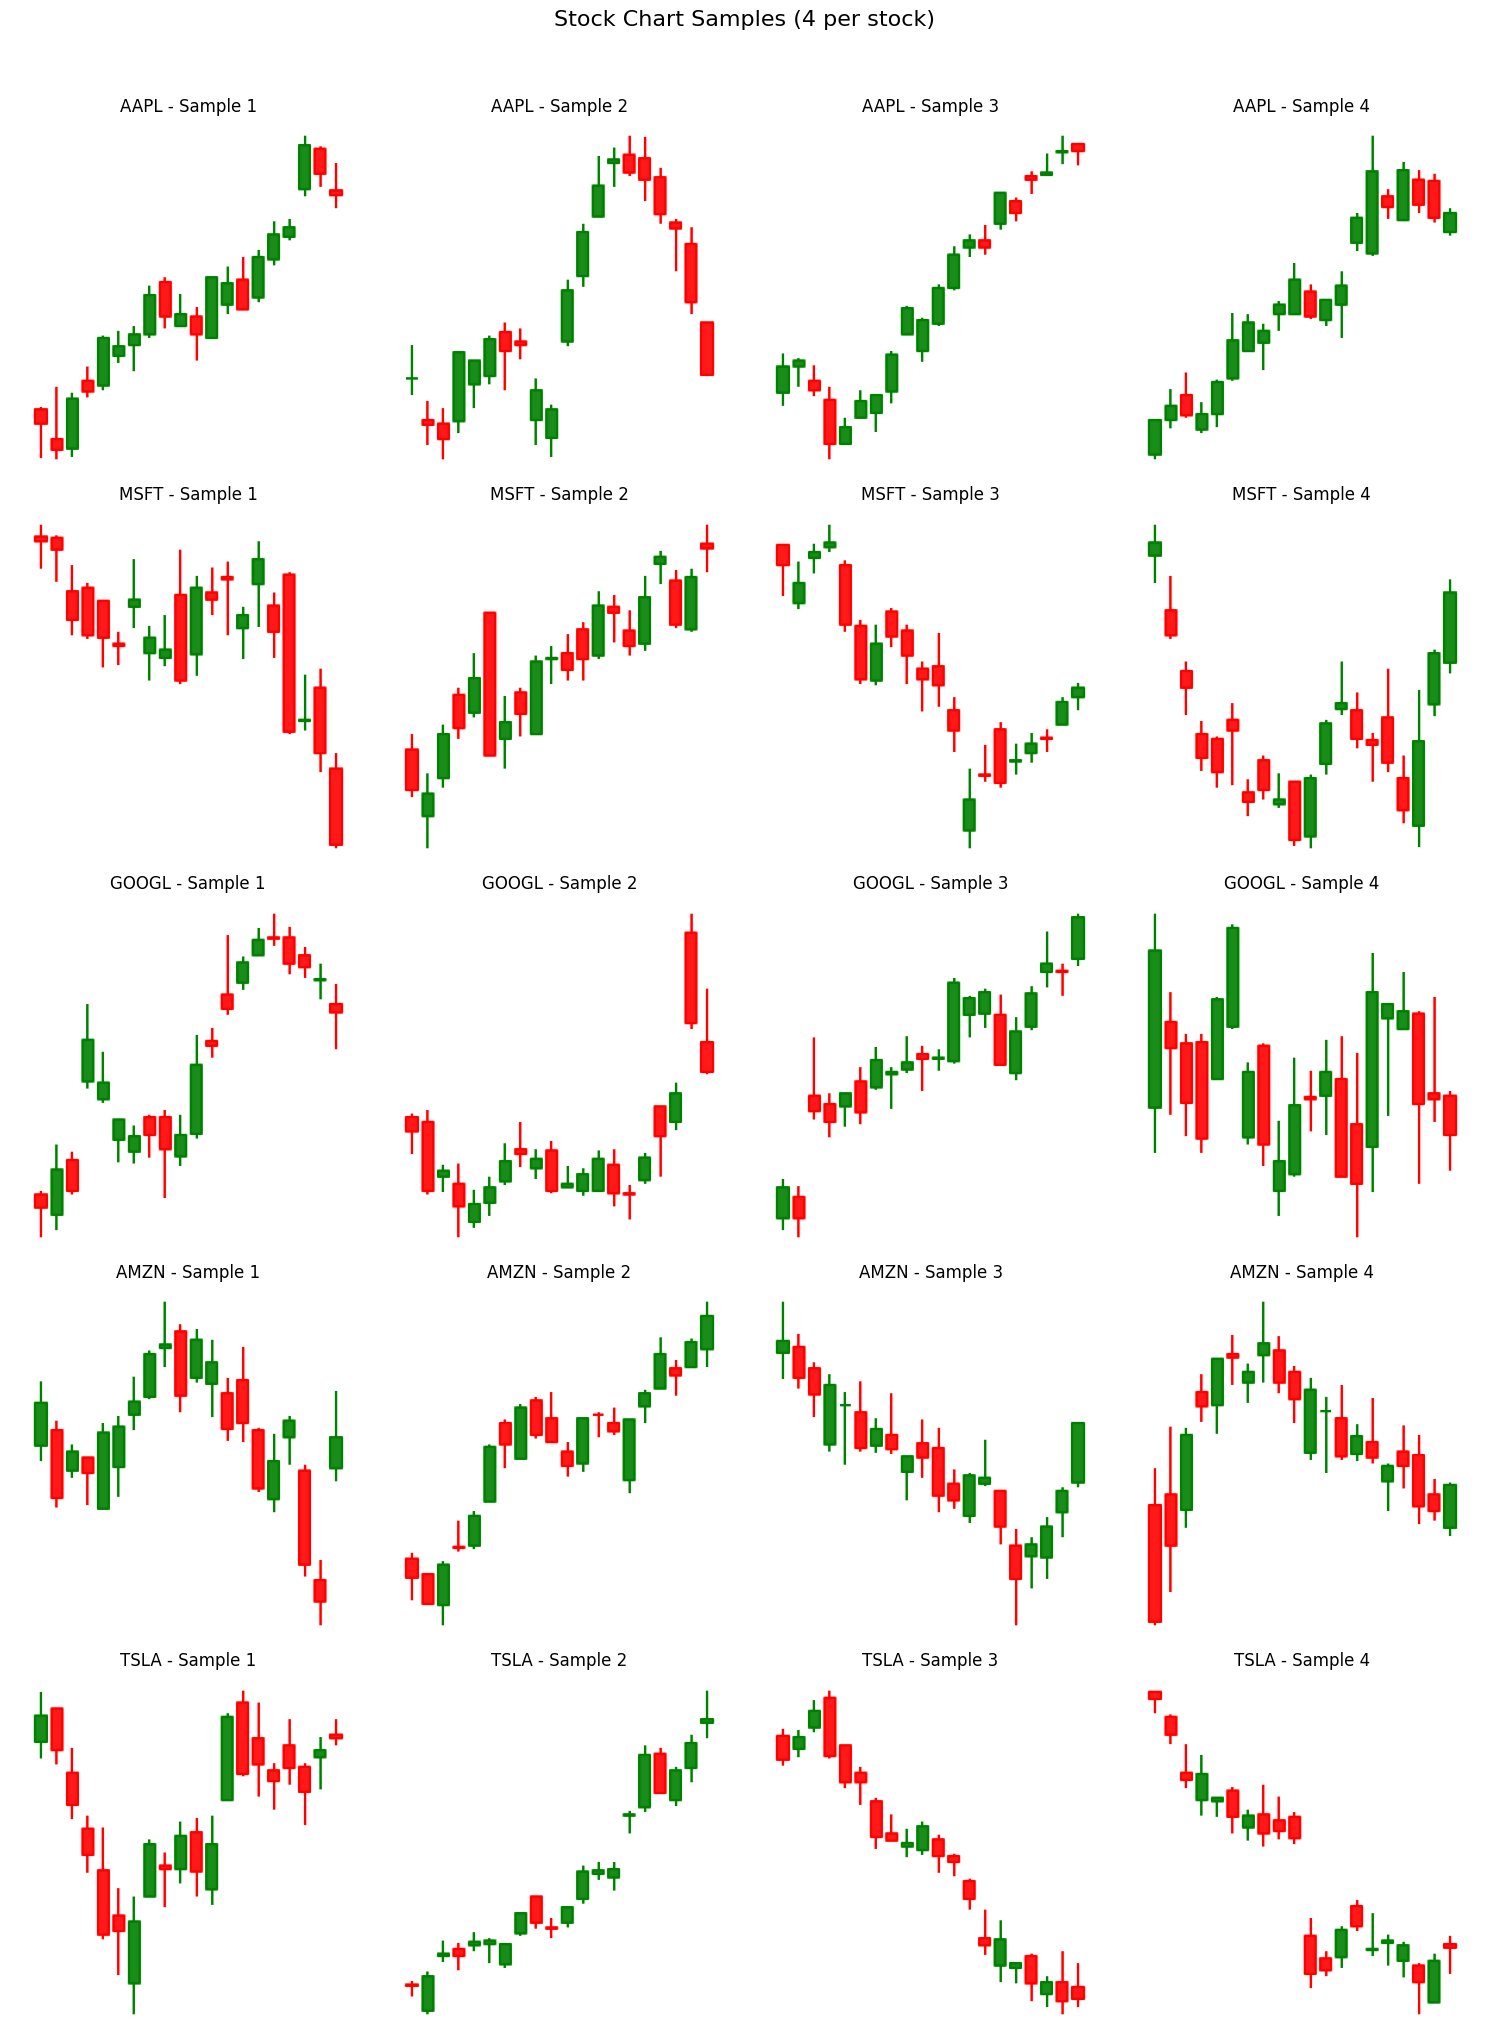


2. Creating balanced dataset...

Displaying pattern samples (5 per pattern)...


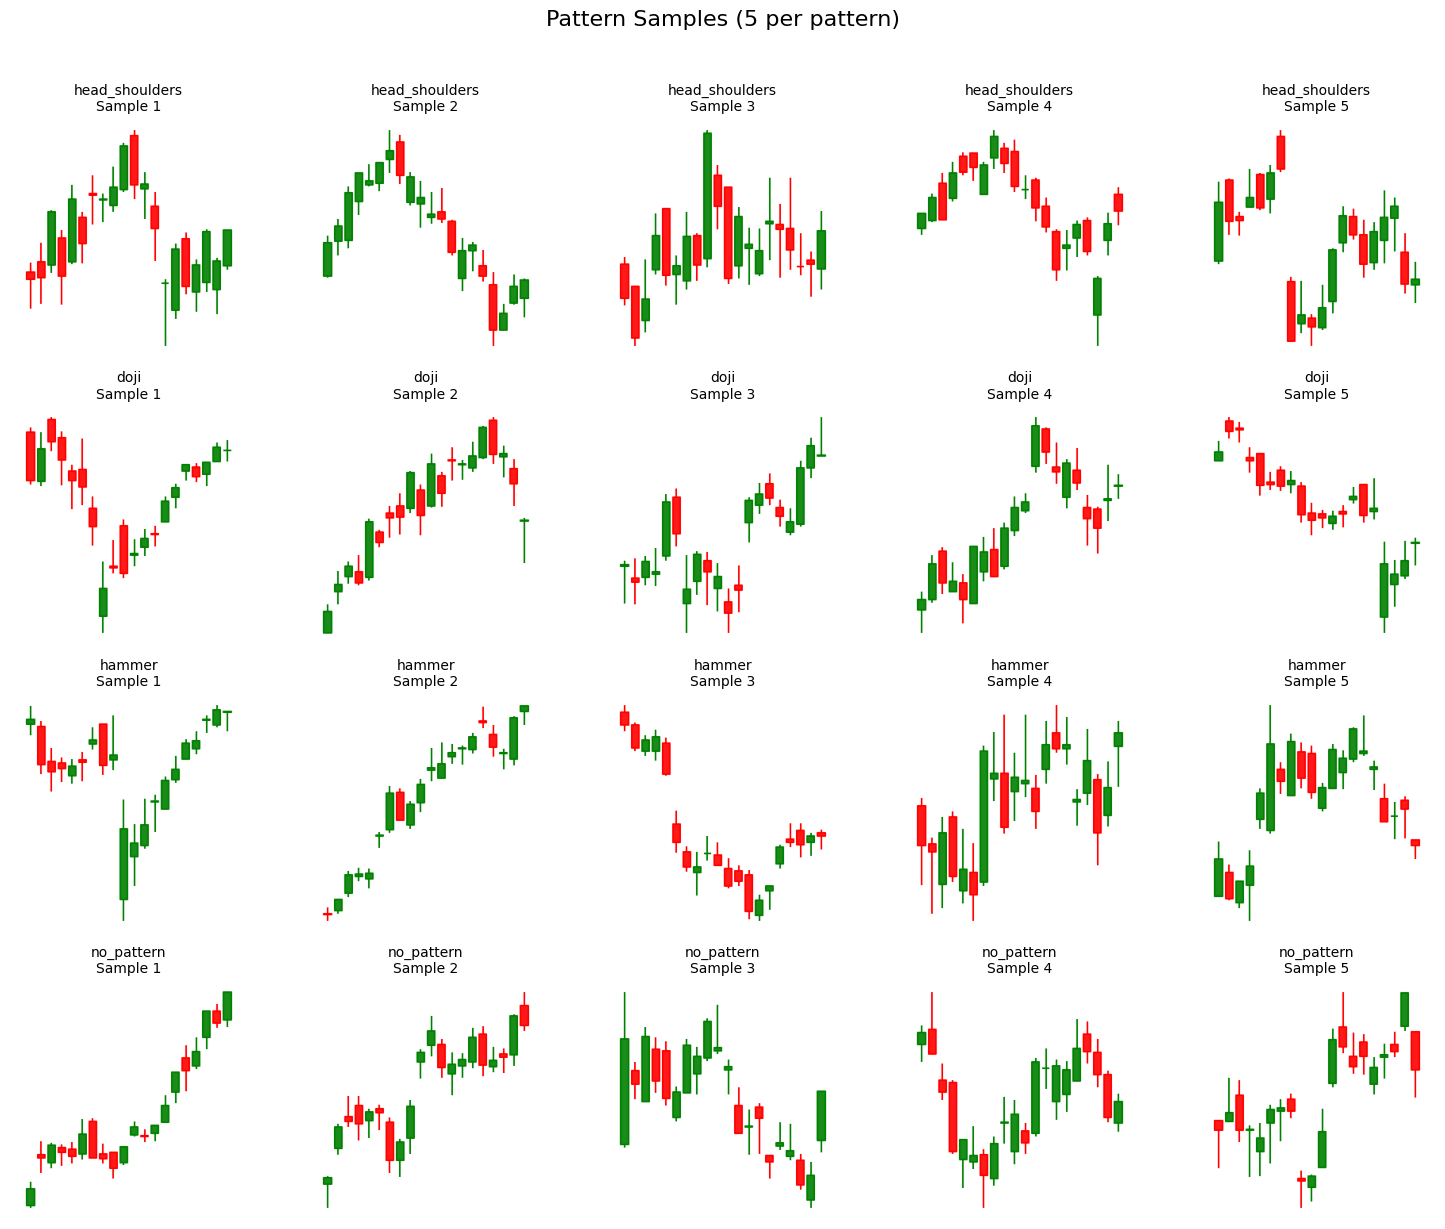


Balanced dataset size: 754
Balanced label distribution: Counter({'no_pattern': 300, 'head_shoulders': 234, 'doji': 124, 'hammer': 96})

Dataset split:
Train: 452 samples
Validation: 151 samples
Test: 151 samples

3. Building and training CNN model...


2026-01-11 14:57:58.367206: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,276 (24.52 KB)

 Trainable params: 6,276 (24.52 KB)

 Non-trainable params: 0 (0.00 B)


Training model...
Epoch 1/30
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.4110 - loss: 1.3161 - val_precision: 0.1579 - val_recall: 0.3974 - val_f1: 0.2260
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 311ms/step - accuracy: 0.4089 - loss: 1.3159 - val_accuracy: 0.3974 - val_loss: 1.2909 - learning_rate: 0.0010 - val_precision: 0.1579 - val_recall: 0.3974 - val_f1: 0.2260
Epoch 2/30
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.3948 - loss: 1.2845 - val_precision: 0.1579 - val_recall: 0.3974 - val_f1: 0.2260
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 301ms/step - accuracy: 0.3936 - loss: 1.2874 - val_accuracy: 0.3974 - val_loss: 1.2926 - learning_rate: 0.0010 - val_precision: 0.1579 - val_recall: 0.3974 - val_f1: 0.2260
Epoch 3/30
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.3745 - loss: 1.2944 - val_precision: 0.1579 - val_recall: 0.3974 - val_f1: 0.2260
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - accuracy: 0.3744 - loss: 1.2953 - val_accuracy: 0.3974 - val_loss: 1.2932 - learning_rat

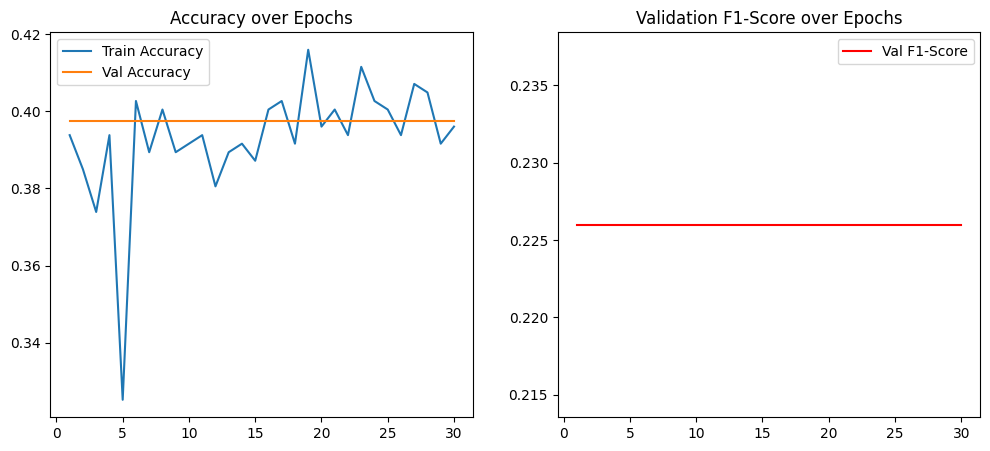


COMPLETED: Pattern recognition system built successfully!


In [7]:
def plot_results_old(history, metrics, performance, random_perf, X_test, y_test, dataset):
    """Create visualization plots"""
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Model Performance Summary', fontsize=16, y=1.02)
    
    # Plot training history - Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot training history - Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot metrics
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metric_values = [metrics['accuracy'], metrics['precision'], 
                    metrics['recall'], metrics['f1_score']]
    
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
    bars = axes[0, 2].bar(metric_names, metric_values, color=colors)
    axes[0, 2].set_title('Test Metrics')
    axes[0, 2].set_ylabel('Score')
    axes[0, 2].set_ylim([0, 1])
    for bar, v in zip(bars, metric_values):
        height = bar.get_height()
        axes[0, 2].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                       f'{v:.2%}', ha='center', va='bottom')
    
    # Plot capital growth
    axes[1, 0].bar(['AI Strategy', 'Random Mean'], 
                  [performance['final_capital'], random_perf['mean_final_capital']],
                  color=['#2E86AB', '#A23B72'])
    axes[1, 0].set_title('Final Capital Comparison')
    axes[1, 0].set_ylabel('Capital ($)')
    
    # Plot returns distribution
    if performance['trades']:
        axes[1, 1].hist(performance['trades'], bins=20, alpha=0.7, color='#2E86AB', edgecolor='black')
        axes[1, 1].axvline(x=0, color='red', linestyle='--', alpha=0.5, linewidth=2)
        axes[1, 1].set_title('Trade Returns Distribution')
        axes[1, 1].set_xlabel('Return ($)')
        axes[1, 1].set_ylabel('Frequency')
    
    # Plot Sharpe ratio comparison
    axes[1, 2].bar(['AI Strategy'], [performance['sharpe_ratio']], color='#2E86AB')
    axes[1, 2].axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=2)
    axes[1, 2].set_title('Sharpe Ratio')
    axes[1, 2].set_ylabel('Ratio')
    
    # Plot confusion matrix
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    # Make predictions
    model = PatternCNN().model
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
    
    cm = confusion_matrix(y_test, y_pred)
    
    im = axes[2, 0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[2, 0].set_title('Confusion Matrix')
    axes[2, 0].set_ylabel('True Label')
    axes[2, 0].set_xlabel('Predicted Label')
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[2, 0].text(j, i, format(cm[i, j], 'd'),
                          ha="center", va="center",
                          color="white" if cm[i, j] > thresh else "black")
    
    # Add pattern names
    pattern_names = ['Head&Shoulders', 'Doji', 'Hammer', 'No Pattern']
    axes[2, 0].set_xticks(range(len(pattern_names)))
    axes[2, 0].set_yticks(range(len(pattern_names)))
    axes[2, 0].set_xticklabels(pattern_names, rotation=45)
    axes[2, 0].set_yticklabels(pattern_names)
    
    # Plot win rate
    axes[2, 1].bar(['AI Strategy'], [performance['win_rate']], color='#2E86AB')
    axes[2, 1].set_ylim([0, 1])
    axes[2, 1].set_title('Win Rate')
    axes[2, 1].set_ylabel('Rate')
    axes[2, 1].text(0, performance['win_rate'] + 0.02, f'{performance["win_rate"]:.2%}', 
                   ha='center', va='bottom')
    
    # Plot total return percentage
    axes[2, 2].bar(['AI Strategy'], [performance['total_return_pct']], color='#2E86AB')
    axes[2, 2].axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=2)
    axes[2, 2].set_title('Total Return %')
    axes[2, 2].set_ylabel('Return %')
    axes[2, 2].text(0, performance['total_return_pct'] + (0.1 if performance['total_return_pct'] >= 0 else -0.1), 
                   f'{performance["total_return_pct"]:.2f}%', ha='center', va='center')
    
    plt.tight_layout()
    plt.savefig('results_summary.png', dpi=100, bbox_inches='tight')
    plt.show()

# Main execution
def main():
    # Configuration
    TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
    START_DATE = '2023-01-01'
    END_DATE = '2025-01-01'
    OUTPUT_DIR = 'chart_images'
    
    print("=" * 60)
    print("FINANCIAL PATTERN RECOGNITION SYSTEM")
    print("=" * 60)
    
    # Part 1: Data Pipeline
    print("\n1. Collecting data and creating images...")
    collector = DataCollector(TICKERS, START_DATE, END_DATE)
    data = collector.fetch_data()

    image_paths, labels = collector.create_candlestick_images(window_size=20, output_dir=OUTPUT_DIR)
    
    print(f"\nCreated {len(image_paths)} images")
    print(f"Label distribution: {Counter(labels)}")
    
    # Display stock samples before creating all images
    print("\nDisplaying stock samples (4 per stock)...")
    collector.display_stock_samples(num_samples=4)
    
    # Part 2: Dataset Creation
    print("\n2. Creating balanced dataset...")
    dataset = PatternDataset(image_paths, labels, img_size=(128, 128))
    
    # Display pattern samples
    print("\nDisplaying pattern samples (5 per pattern)...")
    dataset.display_pattern_samples(num_samples=5)
    
    # Balance the dataset
    balanced_paths, balanced_labels = dataset.create_balanced_dataset(max_samples_per_class=300)
    
    print(f"\nBalanced dataset size: {len(balanced_paths)}")
    print(f"Balanced label distribution: {Counter(balanced_labels)}")
    
    # Load and preprocess images
    X, y = dataset.load_and_preprocess_images(balanced_paths, balanced_labels)
    
    # Split data
    X_train, X_val, X_test, y_train, y_val, y_test = dataset.train_val_test_split(X, y)
    
    print(f"\nDataset split:")
    print(f"Train: {len(X_train)} samples")
    print(f"Validation: {len(X_val)} samples")
    print(f"Test: {len(X_test)} samples")
    
    # Part 3: Model Development
    print("\n3. Building and training CNN model...")
    cnn_model = PatternCNN(input_shape=(128, 128, 3), num_classes=4)
    cnn_model.compile_model(learning_rate=0.001)
    
    # Display model summary
    cnn_model.model.summary()
    
    # Train model
    print("\nTraining model...")
    history = cnn_model.train(X_train, y_train, X_val, y_val, epochs=30, batch_size=32)
    
    # Evaluate model
    print("\nEvaluating model...")
    metrics = cnn_model.evaluate(X_test, y_test)
    
    print(f"\nTest Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.2%}")
    print(f"Precision: {metrics['precision']:.2%}")
    print(f"Recall: {metrics['recall']:.2%}")
    print(f"F1-Score: {metrics['f1_score']:.2%}")
    
    # Part 4: Backtesting
    print("\n4. Backtesting strategy...")
    
    # Prepare data for backtesting
    test_data = collector.data['AAPL']  # Using AAPL for backtesting example
    
    # Generate signals for test data
    backtester = Backtester(cnn_model.model, test_data, dataset.label_map)
    
    # For simplicity, use a subset of images for backtesting
    signals, confidence = backtester.generate_signals(X_test[:100])
    
    # Calculate returns
    returns = test_data['Close'].pct_change().dropna().values
    
    # Calculate performance
    performance = backtester.calculate_performance(
        signals[:len(returns)], 
        returns[:len(signals)],
        initial_capital=10000
    )
    
    print(f"\nTrading Performance:")
    print(f"Initial Capital: ${performance['initial_capital']:,.2f}")
    print(f"Final Capital: ${performance['final_capital']:,.2f}")
    print(f"Total Return: {performance['total_return_pct']:.2f}%")
    print(f"Win Rate: {performance['win_rate']:.2%}")
    print(f"Sharpe Ratio: {performance['sharpe_ratio']:.2f}")
    print(f"Total Trades: {performance['total_trades']}")
    
    # Compare with random strategy
    print("\n5. Comparing with random strategy...")
    random_perf = backtester.compare_random_strategy(returns[:100])
    
    print(f"\nRandom Strategy (1000 simulations):")
    print(f"Mean Final Capital: ${random_perf['mean_final_capital']:,.2f}")
    print(f"Std Final Capital: ${random_perf['std_final_capital']:,.2f}")
    print(f"Best Random: ${random_perf['best_random']:,.2f}")
    print(f"Worst Random: ${random_perf['worst_random']:,.2f}")
    
    # Visualization
    print("\n6. Generating visualizations...")
    #plot_results(history, metrics, performance, random_perf, X_test, y_test, dataset)
    plot_results(history)
    
    print("\n" + "=" * 60)
    print("COMPLETED: Pattern recognition system built successfully!")
    print("=" * 60)

if __name__ == "__main__":
    main()